## makemore: part 5
Culmulative review and new stuff

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [1]:
# shuffle up the words (because our training data may have some sort of ordering)
import random
random.seed(42)
random.shuffle(words)

NameError: name 'words' is not defined

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [7]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True # determines whether we use the batch mean and var or running mean and var
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    # this view 
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [8]:
torch.manual_seed(42); # seed rng for reproducibility

---
### Review: Neural Networks
Note that it is redundant to stack two linear layers directly as the combination of two consecutive linear layers is mathematically equivalent to a single linear transformation:
$$y = W_2 (W_1 X + b_1) + b_2=W_2W_1 X + (W_2b_1 + b_2)$$
Which is why deep neural networks have the form shown below:

In [9]:
# original network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 145 # the number of neurons in the hidden layer of the MLP
model = Sequential([
   Embedding(vocab_size, n_embd),
   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
   Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
   Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
   Linear(n_hidden, vocab_size),
])


"""
# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])
"""


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

75350


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #if i == 20000 - 1: break # DEBUG


      0/ 200000: 3.2987
  10000/ 200000: 2.3708
  20000/ 200000: 1.8953
  30000/ 200000: 1.8794
  40000/ 200000: 2.1956
  50000/ 200000: 2.0652
  60000/ 200000: 1.5985
  70000/ 200000: 2.3081
  80000/ 200000: 2.0714
  90000/ 200000: 1.7737
 100000/ 200000: 2.0886
 110000/ 200000: 1.7085
 120000/ 200000: 1.7414
 130000/ 200000: 2.3212
 140000/ 200000: 1.8260
 150000/ 200000: 1.6633
 160000/ 200000: 1.6061
 170000/ 200000: 1.6071
 180000/ 200000: 2.3285
 190000/ 200000: 1.7356


tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


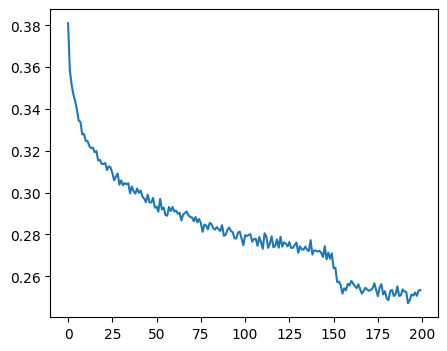

In [11]:
print(torch.arange(0, 10).view(-1, 5)) # eg: with torch.view, rows are always consecutive

#plt.plot(lossi) there is too much entropy during training for this graph to be actually useful
# so we can take take the average of 1000 consecutive samples to get a much nicer graph
plt.figure(figsize=(5, 4))
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

---
### Review: Embedding Layer
In our preprocessing step, we had each example represented as a `block_size` feature vector. Before we can feed it into the NN, we would need to one hot encode each entry in the block to get an `[block_size, 27]` matrix representation of the data, then flatten it into a vector. 
The purpose of the embedding layer is to allow us to use a smaller representation of the data.
In short, `C[27, n_embd]` acts as a lookup table that maps the $27$ characters to a *smaller* `n_embd` vector space (whose values are learned during training). Hence, the tensor `emb` has a dimension of `[batch_size, block_size, n_embd]`, where each `[block_size, n_embd]` matrix corresponds to a sample. Then, we can flatten dim $1$ and dim $2$ together to get a vector representation of each sample for the next layer in the NN.

This layer is not really necessary for (english) character level NNs as english does not use much characters, but this step because essential in *reducing dimensionality* for word level NNs which may have vocabularies in the tens of thousands (or chinese character level NNs which have thousands of characters).

In addition, an embed layer lets the model learn how it should represent characters (or words) in a vocab instead of having the representation fixed (like in the case of one hot encoding). Which allows the model to capture *semantic relationships*. For example, vowels are semantically similar to one another, so they may be mapped more closely together in the `n_embd` vector space. This pattern is more noticable in word level models.





In [12]:
_C = torch.randn(vocab_size, n_embd)
print('C:', _C.shape)
print('Xb:', Xb.shape)
_emb = _C[Xb]
print('emb:', _emb.shape)
_embcat = _emb.view(_emb.shape[0], -1)
print('embcat:', _embcat.shape)


C: torch.Size([27, 24])
Xb: torch.Size([32, 8])
emb: torch.Size([32, 8, 24])
embcat: torch.Size([32, 192])


In [13]:
with torch.no_grad():
    C = model.layers[0].weight

@torch.no_grad()
def k_nearest_neighbors(i, k):
    neighbors = []
    for j in range(1, vocab_size):
        dist = torch.sum((C[i] - C[j])**2)
        neighbors.append((dist, j))
    neighbors = sorted(neighbors)
    for n in neighbors[:k]:
        j = n[1]
        dist = n[0]
        print(f"{itos[i]} : {itos[j]} | dist: {str(dist):2}")

vowels = ['a', 'e', 'i', 'o', 'u']    
for i in range(1, vocab_size):
    if itos[i] in vowels:
        k_nearest_neighbors(i, 5)
        print('')

a : a | dist: tensor(0.)
a : e | dist: tensor(20.8980)
a : i | dist: tensor(25.0571)
a : r | dist: tensor(27.4429)
a : n | dist: tensor(28.6866)

e : e | dist: tensor(0.)
e : a | dist: tensor(20.8980)
e : i | dist: tensor(22.7752)
e : r | dist: tensor(29.6931)
e : n | dist: tensor(32.9591)

i : i | dist: tensor(0.)
i : e | dist: tensor(22.7752)
i : a | dist: tensor(25.0571)
i : y | dist: tensor(29.9073)
i : r | dist: tensor(31.9663)

o : o | dist: tensor(0.)
o : a | dist: tensor(30.7473)
o : e | dist: tensor(37.7703)
o : i | dist: tensor(38.1224)
o : l | dist: tensor(44.7039)

u : u | dist: tensor(0.)
u : a | dist: tensor(47.8242)
u : e | dist: tensor(53.8457)
u : x | dist: tensor(56.7666)
u : i | dist: tensor(56.9930)



As we can see, the 5 nearest neighbors of each vowel in the alphabet are mostly other vowels, which is what we'd expect considering their semantical similarities in the english language.

---
### Wavenet
Increasing the `block_size` improves the performance of the model. However in our previous examples we have not been fully utilizing the additional information that comes from increasing the `block_size`, because we squashed the entire `[block_size, n_embd]` matrix into a single vector to pass into the next layer. Hence, every layer after that layer has no 'knowledge' about the sequential relationships between each character of a block.

We want the model to have knowledge of the sequential relationships between characters in a block. WaveNet does this by flattening the example in each layer. It does so by combining consecutive pair of characters to make what is essentially a block of bigrams. Then it does the same thing for the next layer and so on until we have a vector representation of the example. **I'm not sure if this is true**

##### Block in each layer of the WaveNet-like model
`1 2 3 4 5 6 7 8` $\longrightarrow$ `(1 2) (3 4) (5 6) (7 8)` $\longrightarrow$ `(1 2 3 4) (5 6 7 8)` $\longrightarrow$ `(1 2 3 4 5 6 7 8)`.

In our earlier model, we flattened the sample after the embed layer, so each layer afterwards learns the weights of `(1 2 3 4 5 6 7 8)`, which does not have any sequential information. 
If instead the flattening layer was in the end of the NN, then each layer learns the weights of `1 2 3 4 5 6 7 8 9` which is not too different from a bigram.  **I'm not sure if this is true either**

In a WaveNet-like model, each layer learns the weights of blocks (which double in length in each layer). So, the first layer learns the weights of bigrams. The next learns the weights of 'quadgrams' and so on, which obviously encodes sequence into the model.


In [14]:
print(_emb.shape) # [batch_size, block_size, n_embd]

# matrix multiplication for tensors with a rank greater than two just computes the batches in parallel 
# so the matmul below creates [batch_size, block_size] vectors of size [n_hidden]
_x1 = _emb @ torch.rand((n_embd, n_hidden))
print(_x1.shape) # [batch_size, block_size, n_hidden]
_x1flat = _x1.view(batch_size, block_size//2, -1)
print(_x1flat.shape) # [batch_size, block_size/2, n_hidden*2]

torch.Size([32, 8, 24])
torch.Size([32, 8, 145])
torch.Size([32, 4, 290])


---
### Sample from Model

In [15]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [16]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7433949708938599
val 2.0092387199401855


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

WaveNet-like (76k):
train 1.7690281867980957
val 1.9936517477035522

Original model (75k): train 
1.7433949708938599
val 2.0092387199401855

As we can see, scaling up the network provided the greatest improvement in model performance.
The true advantage of the hierarchal model used by WaveNet is the ability to use convolutions to *massively* improve training and inference speed.

In [22]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

nishaya.
avella.
rayla.
lanyiah.
pandrick.
eliana.
illise.
akira.
ameliami.
gatimus.
miskell.
audaline.
amilah.
lafi.
myra.
santza.
manassabelle.
tathany.
shamsyn.
denis.


### Next time:
Why convolutions? Brief preview/hint

In [18]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [19]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [20]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [21]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space